In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [4]:
fake = pd.read_csv("train.csv")
fake.head()

,id,tid1,tid2,title1_en,title2_en,label
0,195611,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,191474,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,25300,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,123757,2,8,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated
4,141761,2,11,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated


In [5]:
#Counting by Subjects 
for key,count in fake.label.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

unrelated:	175598
agreed:	74238
disagreed:	6606
Total Records:	256442


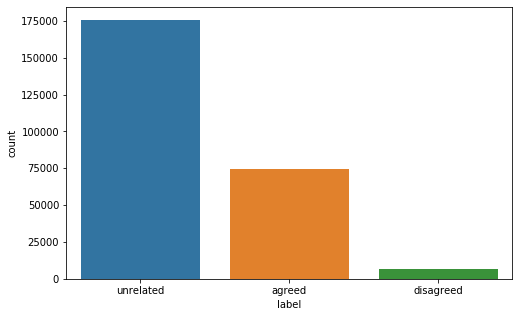

In [7]:
plt.figure(figsize=(8,5))
sns.countplot("label", data=fake)
plt.show()

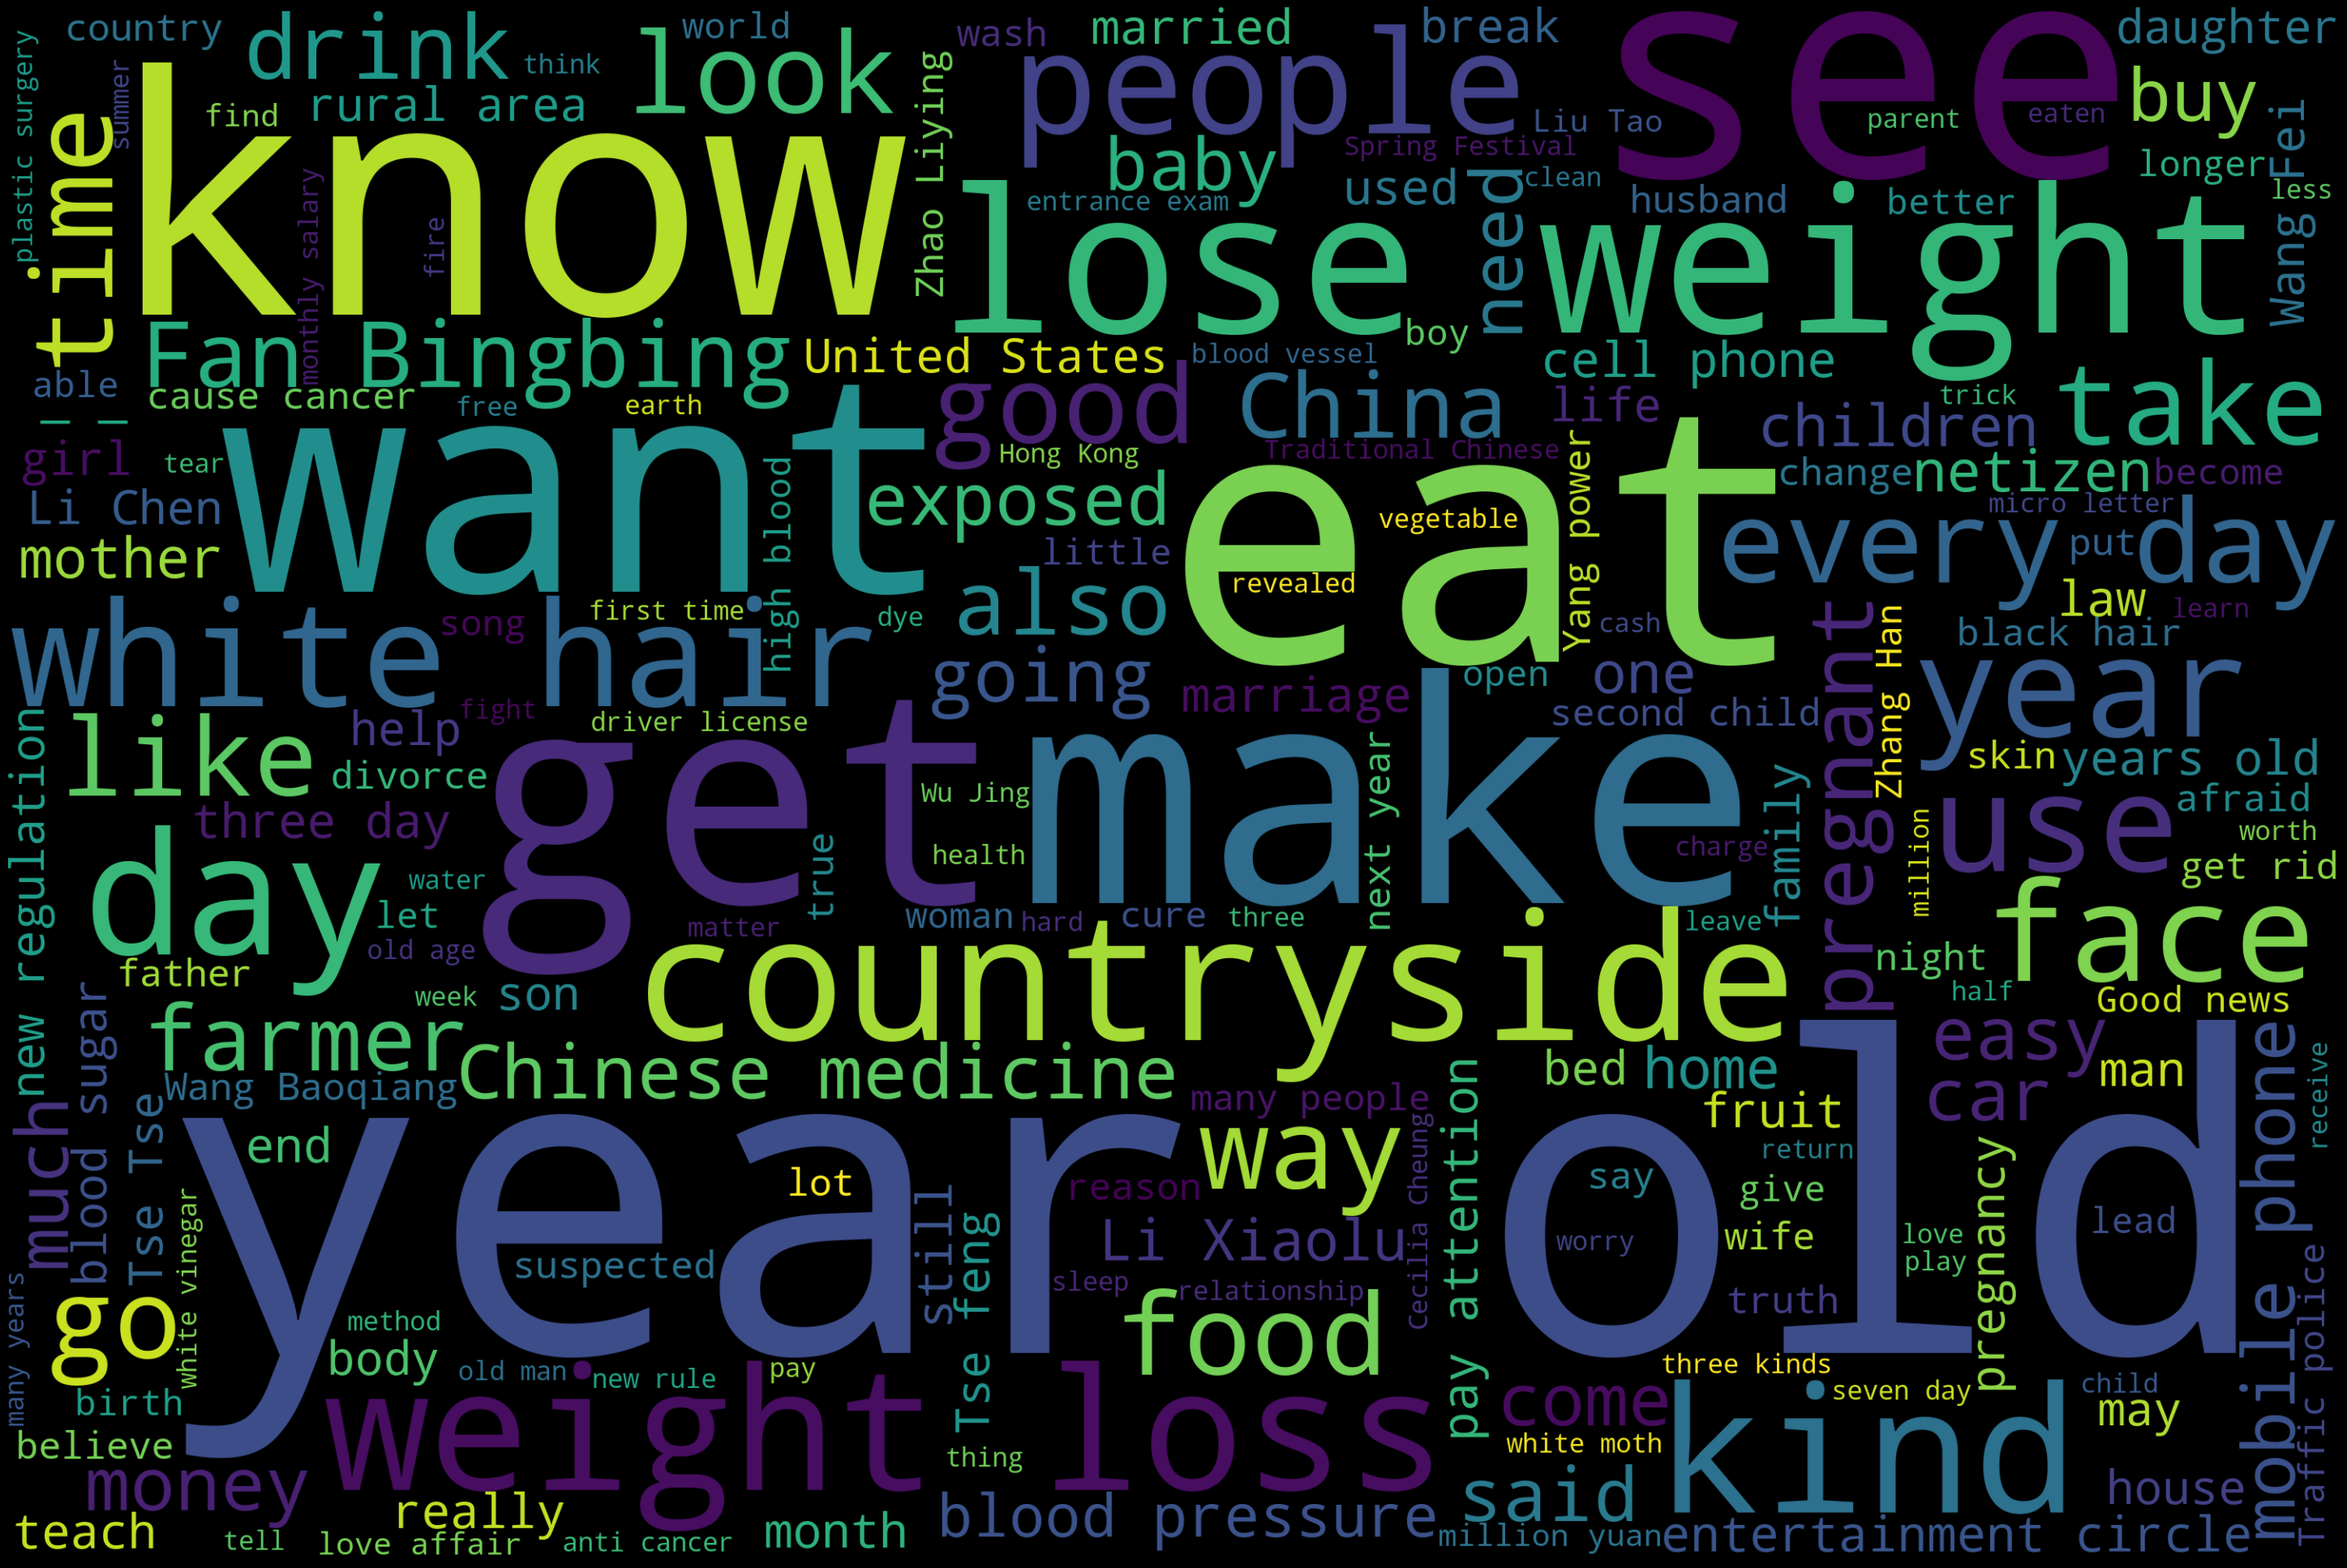

In [9]:
#Word Cloud
text = ''
for news in fake.title1_en.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

In [11]:
fake = fake.drop(["id","tid1","tid2"], axis=1)

In [17]:
data = fake
data.head()

,title1_en,title2_en,label
0,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated
4,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated


In [18]:
data["title1_en"] = data["title1_en"] + " " + data["title2_en"]
data = data.drop(["title2_en"], axis=1)
data.head

<bound method NDFrame.head of                                                 title1_en      label
0       There are two new old-age insurance benefits f...  unrelated
1       "If you do not come to Shenzhen, sooner or lat...  unrelated
2       "If you do not come to Shenzhen, sooner or lat...  unrelated
3       "If you do not come to Shenzhen, sooner or lat...  unrelated
4       "If you do not come to Shenzhen, sooner or lat...  unrelated
...                                                   ...        ...
256437  egypt 's presidential election failed to win m...  unrelated
256438  egypt 's presidential election failed to win m...  unrelated
256439  egypt 's presidential election failed to win m...  unrelated
256440  egypt 's presidential election failed to win m...  unrelated
256441  Will the United States wage war on Iraq withou...  unrelated

[256442 rows x 2 columns]>

In [19]:
y = data["label"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["title1_en"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del data

In [27]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)
#vocab size
len(w2v_model.wv.vocab)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [24]:
X[0][:10]

[18, 6, 3, 180, 448, 699, 3, 7, 40, 382]

In [25]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break    

rumors -> 1
rumor -> 2
old -> 3
year -> 4
eat -> 5
new -> 6
people -> 7
years -> 8
one -> 9
days -> 10


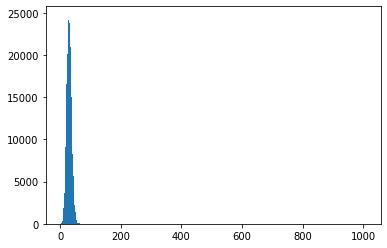

In [26]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :) 

In [34]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 100])
# Out of 256441 news, 256403 have less than 700 words

256403

In [35]:
#Lets keep all news to 100, add padding to news with less than 100 words and truncating long ones
maxlen = 100 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [36]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

100

In [37]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [38]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [61]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [62]:
from tensorflow.keras.layers import BatchNormalization
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

del embedding_vectors

In [63]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          4050600   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 4,168,747
Trainable params: 117,891
Non-trainable params: 4,050,856
_________________________________________________________________


In [64]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
encoder = LabelEncoder()
encoder.fit(y)
labels_val = encoder.transform(y)
labels_val = to_categorical(labels_val)

val_y = labels_val
val_y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [65]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, val_y) 

In [66]:
model.fit(X_train, y_train, validation_split=0.3, epochs=2)

Epoch 1/2
4208/4208 [==============================] - 220s 52ms/step - loss: 0.5861 - acc: 0.7103 - val_loss: 0.5116 - val_acc: 0.7507
Epoch 2/2
4208/4208 [==============================] - 212s 50ms/step - loss: 0.4858 - acc: 0.7693 - val_loss: 0.4671 - val_acc: 0.7813


In [67]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [79]:
predicted_labels = list()
mapping = {0: "agreed", 1: "disagreed", 2: "unrelated"}
for i in range(y_pred.shape[0]):
    predicted_labels.append(mapping[np.argmax(y_pred[i])])
    
predicted_labels

['unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'agreed',
 'agreed',
 'unrelated',
 'unrelated',
 'agreed',
 'agreed',
 'agreed',
 'agreed',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'agreed',
 'agreed',
 'agreed',
 'unrelated',
 'agreed',
 'unrelated',
 'agreed',
 'agreed',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'agreed',


In [80]:
test_labels = list()
mapping = {0: "agreed", 1: "disagreed", 2: "unrelated"}

for i in range(y_test.shape[0]):
    test_labels.append(mapping[list(y_test[i]).index(1)])
    
test_labels

['unrelated',
 'disagreed',
 'unrelated',
 'agreed',
 'agreed',
 'agreed',
 'unrelated',
 'unrelated',
 'disagreed',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'agreed',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'agreed',
 'agreed',
 'unrelated',
 'agreed',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'agreed',
 'agreed',
 'agreed',
 'agreed',
 'unrelated',
 'agreed',
 'disagreed',
 'agreed',
 'unrelated',
 'agreed',
 'unrelated',
 'unrelated',
 'agreed',
 'unrelated',
 'agreed',


In [81]:
accuracy_score(test_labels, predicted_labels)

0.7799597572959398